# Тюнинг линейной регрессии и ошибки

### О задании

В этом задании вы:
- обучите линейную регрессию, познакомитесь с метриками качества в задачах регресии

In [4]:
%pylab inline
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Часть 1. Линейная регрессия

Для начала загрузим данные и разделим их на обучающую и тестовую выборки в соотношении 7 к 3. Зачем так делать? Когда вы проверяете себя на данных на которых не обучались, вы можете быть уверены что не переобучились. Таким образом если качество на 70% датасета (оубчающей выборке) растёт, а на тестовой выборке падает, то модель начала запоминать датасет (переобучилась), вы что-то делаете не так.


In [5]:
data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

__Задание 1.__ Обучение линейной регрессии.

**(4 балла)**

Обучите линейную регрессию с $L_1$ (Lasso) и $L_2$ (Ridge) регуляризаторами (используйте параметры по умолчанию). Посмотрите, какое количество коэффициентов близко к 0 (степень близости к 0 определите сами из разумных пределов). Постройте график зависимости числа ненулевых коэффициентов от коэффицента регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$).

Спойлер - при большом гиперпараметре регуляризации все параметры стремятся к нулю. На графике это должно быть видно.

In [6]:
from sklearn import datasets, linear_model
from sklearn.linear_model import Ridge, Lasso
import numpy as np
import matplotlib.pyplot as plt

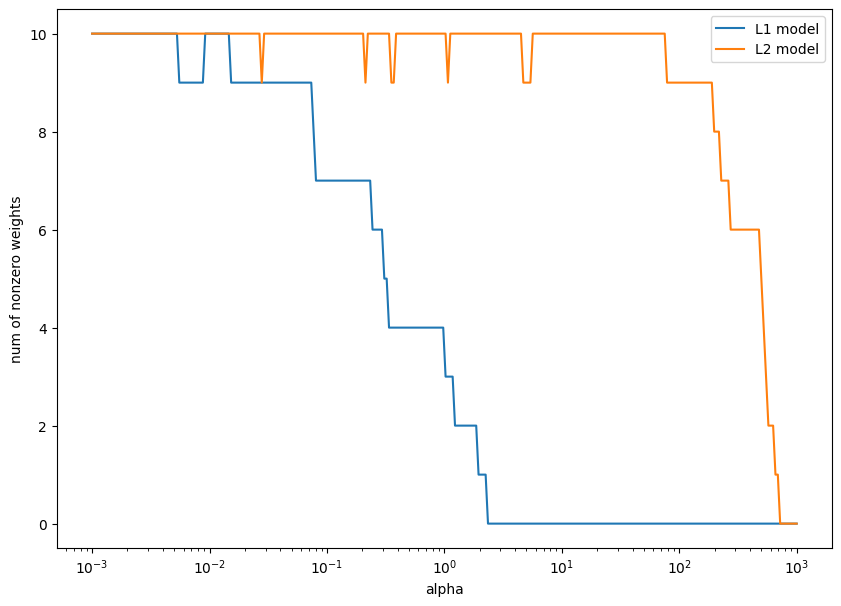

In [ ]:
rang = np.logspace(-3, 3, 300)
l1_num_of_nonzero = []
l2_num_of_nonzero = []
for a in rang:
    l1_model = Lasso(alpha=a, max_iter=30000).fit(X_train, y_train)
    l2_model = Ridge(alpha=a, max_iter=30000).fit(X_train, y_train)

    l1_num_of_nonzero.append(np.sum(np.abs(l1_model.coef_) > 1)) # если меньше, то l2 всегда 10
    l2_num_of_nonzero.append(np.sum(np.abs(l2_model.coef_) > 1))

plt.figure(figsize=(10, 7))
plt.plot(rang, l1_num_of_nonzero, label='L1 model')
plt.plot(rang, l2_num_of_nonzero, label='L2 model')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('num of nonzero weights')
# plt.grid(True, which='minor', linestyle='--', alpha=0.1)
plt.legend()
plt.show()


Посчитайте для Ridge-регрессии следующие метрики: $RMSE$, $MAE$, $R^2$.

In [165]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Подберите на обучающей выборке для Ridge-регрессии коэффициент регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$) для каждой из метрик. Постройте графики зависимости фукнции потерь от коэффициента регуляризации. Посчитайте те же метрики снова. Заметно ли изменилось качество?

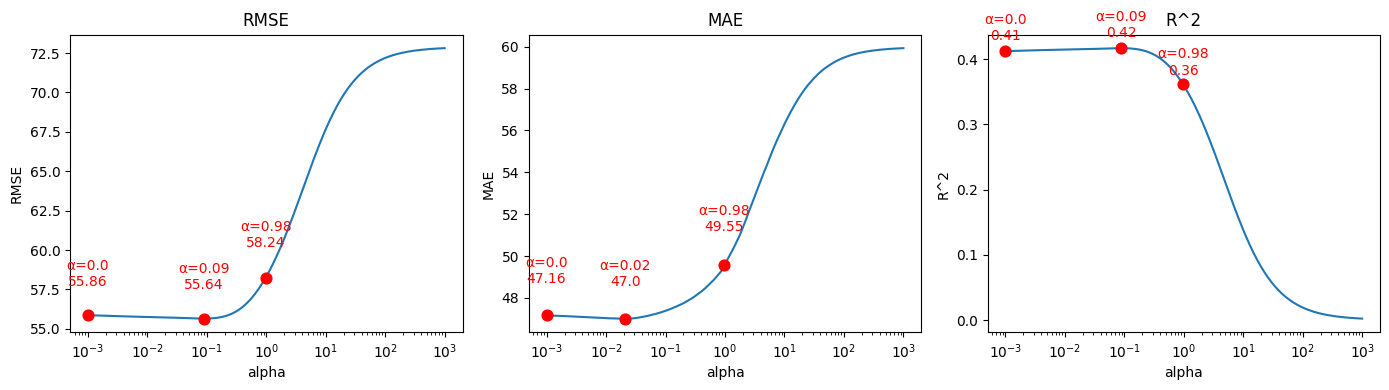

In [206]:

l2_rmse = []
l2_mae = []
l2_rs = []
for a in rang:
    l2_model = Ridge(alpha=a, max_iter=30000).fit(X_train, y_train)
    y_pred = l2_model.predict(X_test)

    l2_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    l2_mae.append(mean_absolute_error(y_test, y_pred))
    l2_rs.append(r2_score(y_test, y_pred))


def show_point(x):
    
    idx = np.argmin(np.abs(rang - x))

    x, y = rang[idx], values[idx]

    plt.scatter(x, y, color="red", s=60, zorder=2)
    plt.text(
        x,
        y * 1.03,
        f"α={round(x, 2)}\n{round(y, 2)}",
        color="red",
        fontsize=10,
        ha="center",
        va="bottom",
    )
plt.figure(figsize=(14, 4))
metrics = {"RMSE": l2_rmse, "MAE": l2_mae, "R^2": l2_rs}
best_points = {"RMSE": rang[np.argmin(l2_rmse)], "MAE": rang[np.argmin(l2_mae)],  "R^2":  rang[np.argmax(l2_rs)]}
for i, (name, values) in enumerate(metrics.items(), 1):
    plt.subplot(1, 3, i)
    plt.plot(rang, values)
    plt.xscale("log")
    plt.xlabel("alpha")
    plt.ylabel(name)
    plt.title(f"{name}")
    show_point(1)
    show_point(0)
    
    show_point(best_points[name])
    


plt.tight_layout()
plt.show()

__Задание 2.__ Поиск объектов-выбросов

**(4 балла)**

Как известно, MSE сильно штрафует за большие ошибки на объектах-выбросах. Посчитайте ошибки и посмотрите на их распределение (plt.hist). Что вы видите?

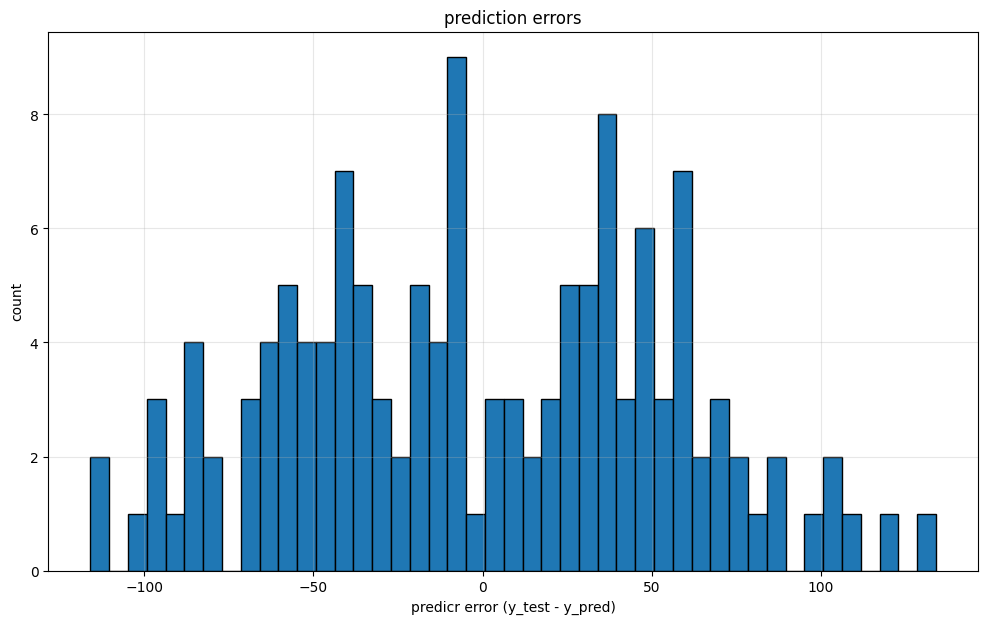

In [207]:
l2_best_mse = Ridge(alpha = best_points["RMSE"], max_iter=30000).fit(X_train, y_train)
y_pred = l2_best_mse.predict(X_test)
diff = y_test - y_pred

plt.figure(figsize=(12, 7))
plt.hist(diff, bins=45, edgecolor='k')
plt.xlabel('predicr error (y_test - y_pred)')
plt.ylabel('count')
plt.title('prediction errors')
plt.grid(True, alpha=0.3)
plt.show()
# распределение не очень нормальное, выбросы есть

Попробуйте удалить объекты-выбросы из обучающей выборки (что считать или не считать выбросами на ваше усмотрение). Обучите модель заново и посмотрите на качество на отложенной выборке (учитывайте, что там тоже могут быть выбросы, с которыми вы ничего не можете сделать). Стало ли лучше? Чем вы можете объяснить это?

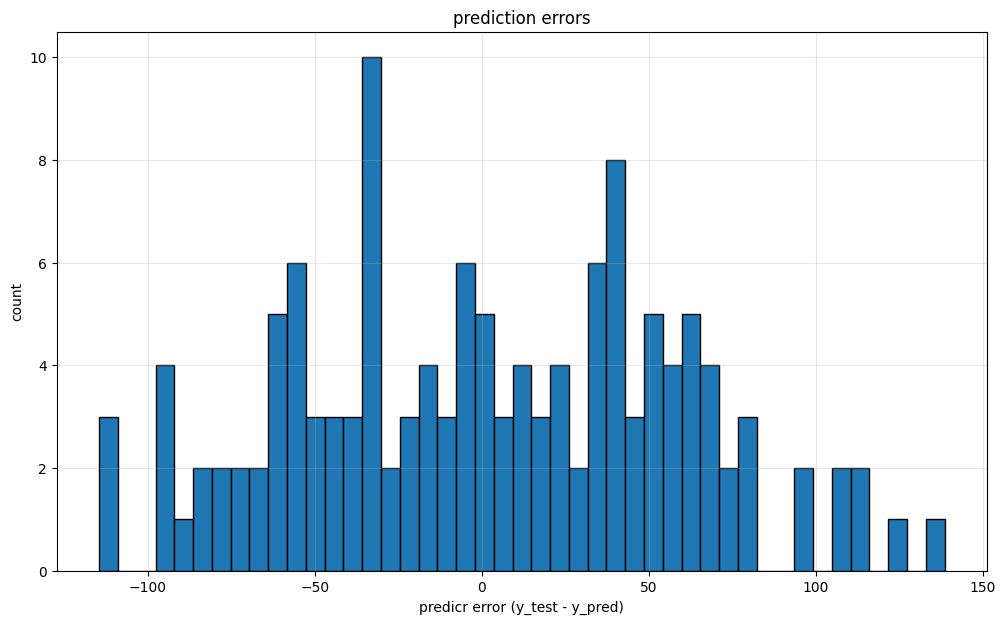

RMSE 56.5176
MAE  47.5278
R^2  0.3985


In [208]:
y_pred = l2_best_mse.predict(X_train)
diff = y_train - y_pred
border = 1.7 * np.std(diff)
keep = np.abs(diff) < border
X_train_filtered = X_train[keep]
y_train_filtered = y_train[keep]

l2_best_mse = Ridge(alpha = best_points["RMSE"], max_iter=30000).fit(X_train_filtered, y_train_filtered)
y_pred = l2_best_mse.predict(X_test)
diff = y_test - y_pred

plt.figure(figsize=(12, 7))
plt.hist(diff, bins=45, edgecolor='k')
plt.xlabel('predicr error (y_test - y_pred)')
plt.ylabel('count')
plt.title('prediction errors')
plt.grid(True, alpha=0.3)
plt.show()

rmse_filtered = np.sqrt(mean_squared_error(y_test, y_pred))
mae_filtered = mean_absolute_error(y_test, y_pred)
r2_filtered = r2_score(y_test, y_pred)

print(f"RMSE {rmse_filtered:.4f}")
print(f"MAE  {mae_filtered:.4f}")
print(f"R^2  {r2_filtered:.4f}")

# стало лучше, потому что удалили данные, которые буквально делают ошибку больше


__Задание 3.__ Отчёт

**(2 балла)**

Интересно, что в первом задании l2 выше l1, видимо там все веса меньше единицы и вообще тогда грустно получилось, и в таком случае l2 странно работает

1.4137931034482758 6 1.4137931034482758 54.89834250520152
1.2758620689655173 4 1.2758620689655173 46.175524673877604
1.4137931034482758 6 1.4137931034482758 0.4325026711205481


C:\Users\forxh\AppData\Local\Temp\ipykernel_20268\2913543681.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


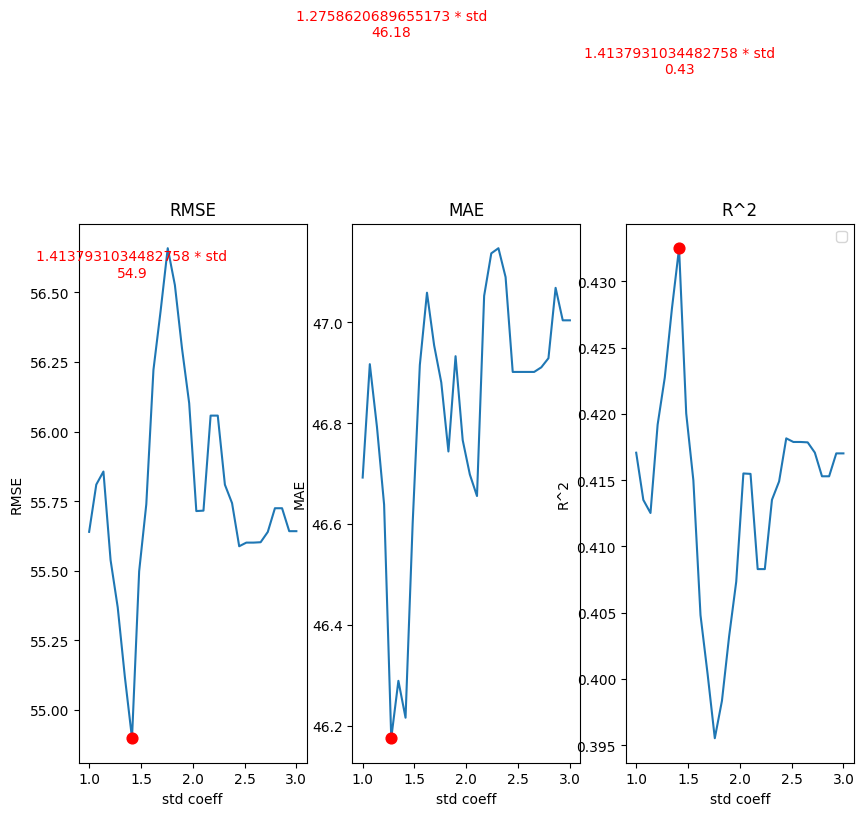

In [ ]:
# интересно посмотреть на лучшие ошибки при разной степени очистки данных

rang_log = np.logspace(-3, 3, 30)
rang_lin = np.linspace(1, 3, 30)

best_rmse = []
best_mae = []
best_r2 = []
for l in rang_lin:
    l2_rmse = []
    l2_mae = []
    l2_r2 = []
    for a in rang_log:
        l2_model = Ridge(alpha=a, max_iter=300).fit(X_train, y_train)
        y_pred = l2_model.predict(X_train)
        diff = y_train - y_pred
        border = l * np.std(diff)
        keep = np.abs(diff) < border
        X_train_filtered = X_train[keep]
        y_train_filtered = y_train[keep]
        l2_model = Ridge(alpha=a, max_iter=300).fit(X_train_filtered, y_train_filtered)
        y_pred = l2_model.predict(X_test)
        l2_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        l2_mae.append(mean_absolute_error(y_test, y_pred))
        l2_r2.append(r2_score(y_test, y_pred))
    
    best_rmse.append(min(l2_rmse))
    best_mae.append(min(l2_mae))
    best_r2.append(max(l2_r2))


plt.figure(figsize=(10, 7))
metrics = {"RMSE": best_rmse, "MAE": best_mae, "R^2": best_r2}
# best_points = {"RMSE": rang_lin[np.argmin(l2_rmse)], "MAE": rang[np.argmin(l2_mae)],  "R^2":  rang[np.argmax(l2_rs)]}
best_points = {"RMSE": rang_lin[np.argmin(best_rmse)], "MAE": rang_lin[np.argmin(best_mae)],  "R^2":  rang_lin[np.argmax(best_r2)]}
def show_point(x, values):
    
    idx = np.argmin(np.abs(rang_lin - x))
    x, y = rang_lin[idx], values[idx]
    print(x, idx, rang_lin[idx], y)
    
    plt.scatter(x, y, color="red", s=60, zorder=2)
    plt.text(
        x,
        y * 1.03,
        f"{x} * std\n{round(y, 2)}",
        color="red",
        fontsize=10,
        ha="center",
        va="bottom",
    )
for i, (name, values) in enumerate(metrics.items(), 1):
    plt.figure(10, 7)
    # plt.subplot(1, 3, i, label = name)
    plt.plot(rang_lin, values)
    plt.xlabel("std coeff")
    plt.ylabel(name)
    plt.title(f"{name}")
    
    show_point(best_points[name], values)
# plt.grid(True, which='minor', linestyle='--', alpha=0.1)
plt.legend()
plt.show()